# Multi-class text classification with LSTM

This notbook describes a case study of multi-class text classfication on Consumer Complaint Database using LSTM (Long Short Term Memory) Deep learning model.

### About Data

> Consumer Complaint Database: This dataset is provided publically by Consumer Financial Protection Bureau (CFPB). The Consumer Complaint Database is a collection of complaints about consumer financial products and services that CFPB sends to companies for response regularly. Those complaints are published after the company responds, confirming a commercial relationship with the consumer, or after 15 days, whichever comes first.


>  Original data (zip ~349 MB, extracted ~ 1.33 GB) is available in .csv at https://catalog.data.gov/dataset/consumer-complaint-database

### Brief About type of Features ( text + categorical feature + numerical feature)

> Data has text (the complaint narration) along with some categorical variables like location, city, mode of communication etc. The complaint narration feature is the main feature for us. 

> To learn how to use numerical features with LSTM, we will create our own numerical feature.

> So final data will have text, categorical and numerical features, which makes it a very intersting and challenging problem.



### Task:

> In the task, given set of features (text-complaint, cateogrical features, numerical feature), we want to build a model to predict the category of the complaint.


# 1. Importing libraries

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from IPython.display import display, HTML
import nltk
import string
import matplotlib.pyplot as plt
from termcolor import colored
import seaborn as sns


# 2. Reading the data and Analysing it

In [2]:
#reading the data
df = pd.read_csv("complaints.csv")


In [3]:
#first 5 rows of the data
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-06-13,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,PA,186XX,NaN,Consent not provided,Web,2019-06-13,Closed with explanation,Yes,NaN,3274605
1,2019-04-01,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",PA,19067,NaN,Consent not provided,Web,2019-04-01,Closed with explanation,Yes,NaN,3198225
2,2021-05-28,"Credit reporting, credit repair services, or o...",Credit reporting,Unable to get your credit report or credit score,Problem getting your free annual credit report,NaN,NaN,"EQUIFAX, INC.",WA,98026,NaN,Other,Web,2021-05-28,Closed with explanation,Yes,NaN,4412190
3,2021-05-28,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,NaN,NaN,"EQUIFAX, INC.",AL,35211,NaN,Consent not provided,Web,2021-05-28,Closed with explanation,Yes,NaN,4414038
4,2021-06-16,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",TX,773XX,NaN,NaN,Web,2021-06-16,Closed with explanation,Yes,NaN,4467932


In [4]:
#shape of the data
df.shape

(2207240, 18)

> Data has 2207240 rows and 18 columns.

### Column Details

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2207240 entries, 0 to 2207239
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 303.

### Renaming the columns

In [6]:
#https://datagy.io/rename-pandas-columns/
df = df.rename(mapper=lambda x: x.strip().replace(' ', '_').replace('?', '').replace('-', '_').lower(), axis=1)

print(df.columns)

Index(['date_received', 'product', 'sub_product', 'issue', 'sub_issue',
       'consumer_complaint_narrative', 'company_public_response', 'company',
       'state', 'zip_code', 'tags', 'consumer_consent_provided',
       'submitted_via', 'date_sent_to_company', 'company_response_to_consumer',
       'timely_response', 'consumer_disputed', 'complaint_id'],
      dtype='object')


### Checking for duplicates

In [7]:
df.duplicated().sum()

0

> There are no duplicates.

### Observations About data

> There can be two target variables. product and sub_product. For now, we will only consider product as our target. sub_product is closely mapped to product vaiable. Hence we will remove the sub_product variable.

> Similarly issue and sub_issue are also very closely mapped to our target variable product. i.e. issue and sub_issue are children of product. Hence these need to be removed. 

> Variable complaint_id contains no information. It can be removed.

In [8]:
#removing sub_product, issue, sub_issue  and complaint_id
df= df.drop(columns=['issue', 'sub_issue', 'sub_product', 'complaint_id'])


### Checking for null values

In [9]:
#https://stackoverflow.com/questions/51070985/find-out-the-percentage-of-missing-values-in-each-column-in-the-given-dataset/51071037
total_missing = df.isnull().sum()
percent_missing = df.isnull().sum() * 100 / len(df)


missing_value_df = pd.DataFrame({'total_missing': total_missing,'percent_missing': percent_missing})
missing_value_df

,total_missing,percent_missing
date_received,0,0.000000
product,0,0.000000
consumer_complaint_narrative,1446846,65.550008
company_public_response,1292661,58.564587
company,0,0.000000
state,41342,1.873018
zip_code,218471,9.897927
tags,1933275,87.587893
consumer_consent_provided,720650,32.649372
submitted_via,0,0.000000


> Data has lot of null values.

> Firstly, our main feature is consumer_complaint_narrative. We will remove the rows which have null value for consumer_complaint_narrative

In [10]:
#removing rows having null complaints
df = df[~df['consumer_complaint_narrative'].isnull() ]

In [11]:
df.reset_index(inplace = True, drop = True)

In [12]:
df.shape

(760394, 14)

> from 2207240 rows to now we have 760394 rows. This is still a huge data for a RAM of 8GB. We will only take 100k rows to reduce the data, which is still a good amount of data for us to build a decent model. Before than let's look at the classes.

In [13]:
df['product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    289244
Debt collection                                                                 148677
Mortgage                                                                         81546
Credit card or prepaid card                                                      57063
Checking or savings account                                                      34626
Credit reporting                                                                 31588
Student loan                                                                     28606
Credit card                                                                      18838
Money transfer, virtual currency, or money service                               16924
Bank account or service                                                          14885
Vehicle loan or lease                                                            14043
Payday loan, title loan, or personal loan  

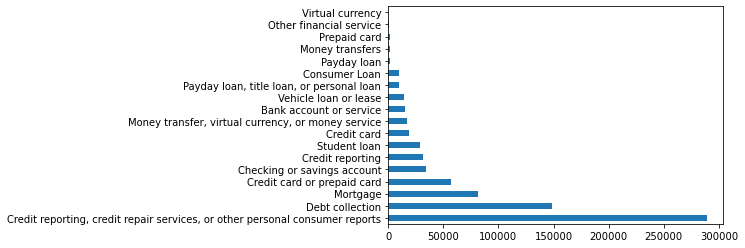

In [14]:
#https://stackoverflow.com/questions/36762199/using-pandas-value-counts-and-matplotlib

CountStatus = pd.value_counts(df['product'].values, sort=True)
CountStatus.plot.barh()


#### Observations

> "Credit reporting" can be merged with "Credit reporting, credit repair services, or other personal consumer reports"

> "Credit card" can be merged with "Credit card or prepaid card"

> "Prepaid card" can be merged with "Credit card or prepaid card"

> "Payday loan" can be merged with "Payday loan, title loan, or personal loan"

> "Money transfers" can be merged with "Money transfer, virtual currency, or money service"

> "Virtual currency" can be merged with "Money transfer, virtual currency, or money service"

> "Other financial service" has only 16 rows. It can be removed.

### label consolidation

In [15]:
#label consolidation
#https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17
df.loc[df['product'] == 'Credit reporting', 'product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
df.loc[df['product'] == 'Credit card', 'product'] = 'Credit card or prepaid card'
df.loc[df['product'] == 'Payday loan', 'product'] = 'Payday loan, title loan, or personal loan'
df.loc[df['product'] == 'Virtual currency', 'product'] = 'Money transfer, virtual currency, or money service'
df.loc[df['product'] == 'Money transfers', 'product'] = 'Money transfer, virtual currency, or money service'
df.loc[df['product'] == 'Prepaid card', 'product'] = 'Credit card or prepaid card'
df = df[df['product'] != 'Other financial service']

In [16]:
df['product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    320832
Debt collection                                                                 148677
Mortgage                                                                         81546
Credit card or prepaid card                                                      77351
Checking or savings account                                                      34626
Student loan                                                                     28606
Money transfer, virtual currency, or money service                               18437
Bank account or service                                                          14885
Vehicle loan or lease                                                            14043
Payday loan, title loan, or personal loan                                        11628
Consumer Loan                                                                     9471
Name: product, dtype: int64

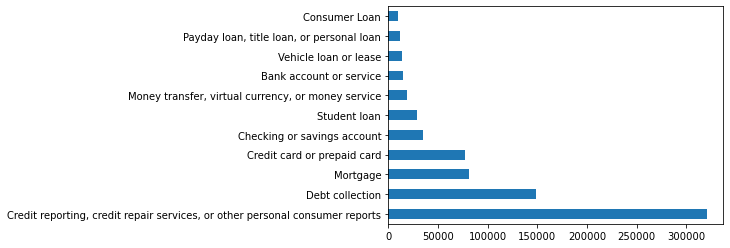

In [17]:
CountStatus = pd.value_counts(df['product'].values, sort=True)
CountStatus.plot.barh()

In [18]:
df.reset_index(inplace = True, drop= True)


# 3. Sampling 100k rows

> Now we will randomly select only 100k rows from the dataset due to system limitation. My system has 8GB RAM, which is sufficient for 100k rows.

In [19]:
df = df.sample(n = 100000)

In [20]:
df.to_csv("complaint_100k.csv")

In [238]:
df = pd.read_csv("complaint_100k.csv")

In [239]:
df['product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    42009
Debt collection                                                                 19693
Mortgage                                                                        10747
Credit card or prepaid card                                                     10251
Checking or savings account                                                      4457
Student loan                                                                     3747
Money transfer, virtual currency, or money service                               2441
Bank account or service                                                          2013
Vehicle loan or lease                                                            1874
Payday loan, title loan, or personal loan                                        1524
Consumer Loan                                                                    1244
Name: product, dtype: int64

# 4. Basic Analysis and Cleaning

#### Checking the Null Values again

In [240]:
#https://stackoverflow.com/questions/51070985/find-out-the-percentage-of-missing-values-in-each-column-in-the-given-dataset/51071037
total_missing = df.isnull().sum()
percent_missing = df.isnull().sum() * 100 / len(df)


missing_value_df = pd.DataFrame({'total_missing': total_missing,'percent_missing': percent_missing})
missing_value_df

,total_missing,percent_missing
Unnamed: 0,0,0.000
date_received,0,0.000
product,0,0.000
consumer_complaint_narrative,0,0.000
company_public_response,50881,50.881
company,0,0.000
state,564,0.564
zip_code,22049,22.049
tags,83867,83.867
consumer_consent_provided,0,0.000


> Now consumer_complaint_narrative has zero null values.

> Now we will focus on the variables which have null values. company_public_response, state, zip_code, tags, consumer_disputed.

> Before that, let's check the unique values of each variable.

In [241]:
#unique value of each variable
for n, i in enumerate(df.columns):
    print('----------------')
    print('Var - '+str(n+1)+' - '+df.columns[n] ) 
    print('Total unique values = ' +str(len(df[i].value_counts())))
  
    
    if len(df[i].value_counts())<=11:
        print(df[i].value_counts())
        print('****************')
    print('----------------')

----------------
Var - 1 - Unnamed: 0
Total unique values = 100000
----------------
----------------
Var - 2 - date_received
Total unique values = 2317
----------------
----------------
Var - 3 - product
Total unique values = 11
Credit reporting, credit repair services, or other personal consumer reports    42009
Debt collection                                                                 19693
Mortgage                                                                        10747
Credit card or prepaid card                                                     10251
Checking or savings account                                                      4457
Student loan                                                                     3747
Money transfer, virtual currency, or money service                               2441
Bank account or service                                                          2013
Vehicle loan or lease                                                            18

##### Observations:

> total unique values in consumer_consent_provided and submitted_via have only one unique value. These two variable can be deleted.

> For null values of company_public_response, state, tags, consumer_disputed, we will replace null values by "not known" 

> For company_response_to_consumer, we have only one null value. Since this is only one row, we can remove this row.

In [100]:
#dropping consumer_consent_provided and submitted_via as they have only one unique value.
df= df.drop(columns=['consumer_consent_provided', 'submitted_via'])


In [242]:
#imputing the misssing values as "not known" in company_public_response, state, tags, consumer_disputed
df['company_public_response'] = df['company_public_response'].fillna("unknown")
df['state'] = df['state'].fillna("unknown")
df['tags'] = df['tags'].fillna("unknown")
df['consumer_disputed'] = df['consumer_disputed'].fillna("unknown")


In [243]:
#dropping row which has null value for company_response_to_consumer
df = df[~df['company_response_to_consumer'].isnull() ]
df.reset_index(inplace = True, drop = True)

In [244]:
#checking the zip code:
df['zip_code'][10:20]

10    900XX
11    461XX
12    60415
13    330XX
14    937XX
15      NaN
16    923XX
17    386XX
18      NaN
19    802XX
Name: zip_code, dtype: object

> It can be seen that zipcode does not contain accurate information (XX in most of the zip code, and 22% null values). Hence we will remove zip code column.

In [245]:
#removing zip_code column
df= df.drop(columns=['zip_code'])


In [246]:
#checking the null values again
total_missing = df.isnull().sum()
percent_missing = df.isnull().sum() * 100 / len(df)


missing_value_df = pd.DataFrame({'total_missing': total_missing,'percent_missing': percent_missing})
missing_value_df

,total_missing,percent_missing
Unnamed: 0,0,0.0
date_received,0,0.0
product,0,0.0
consumer_complaint_narrative,0,0.0
company_public_response,0,0.0
company,0,0.0
state,0,0.0
tags,0,0.0
consumer_consent_provided,0,0.0
submitted_via,0,0.0


> Now we don't have any null values.

### Creating Numerical features

> There are two date columns: date_received and date_sent_to_company. We will find the lowest date and mark it as reference, and convert each date into numeric format as a differene in number of days from the reference date. 

> We will create one more numeric feature by simply calculaing length of each consumer_complaint_narrative. 

> Please note that above two steps might not be useful to the model at all. We are doing it just to get some numerical features. So that we can explore how to use numerical features along with LSTM models.

#### From the date features

In [247]:
#https://stackoverflow.com/questions/23178129/getting-min-and-max-dates-from-a-pandas-dataframe

reference_date = min(df.date_received.min(), df.date_sent_to_company.min())
print(reference_date)

2015-03-19


In [248]:
#now we will calculate difference of the dates from the reference date in terms of number of days
df['date_received'] = pd.to_datetime(df['date_received'])
df['date_sent_to_company'] = pd.to_datetime(df['date_sent_to_company'])
df['date_received_days'] = (df['date_received'] - datetime.strptime(reference_date, '%Y-%m-%d')).dt.days
df['date_sent_to_company_days'] = (df['date_sent_to_company'] - datetime.strptime(reference_date, '%Y-%m-%d')).dt.days

In [249]:
print(df['date_received_days'].min())
print(df['date_received_days'].max())

df['date_received_days'].values

0
2317


array([1268, 2050, 1785, ...,  396, 2120, 2102], dtype=int64)

In [250]:
print(df['date_sent_to_company_days'].min())
print(df['date_sent_to_company_days'].max())

df['date_sent_to_company_days'].values

0
2323


array([1274, 2050, 1785, ...,  396, 2120, 2121], dtype=int64)

#### From the consumer_complaint_narrative feature

In [251]:
#calculating length of each complaint text. This will take a while to run.
df['totalwords'] = df['consumer_complaint_narrative'].str.split().str.len()
df['totalwords'].head()

0     18
1    298
2    395
3    142
4    204
Name: totalwords, dtype: int64

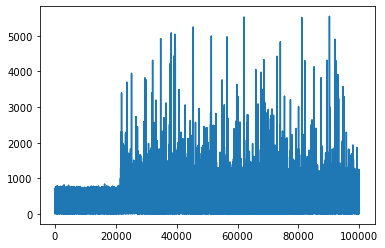

In [431]:
df['totalwords'].plot()

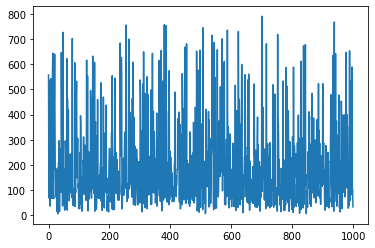

In [437]:
df['totalwords'][0:1000].plot()

### Cleaning the text data

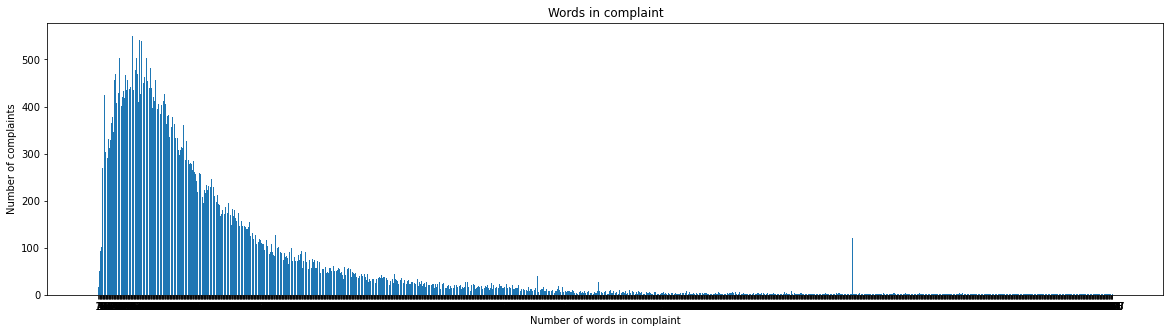

In [252]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = df['consumer_complaint_narrative'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[0]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Number of complaints')
plt.xlabel('Number of words in complaint')
plt.title('Words in complaint')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

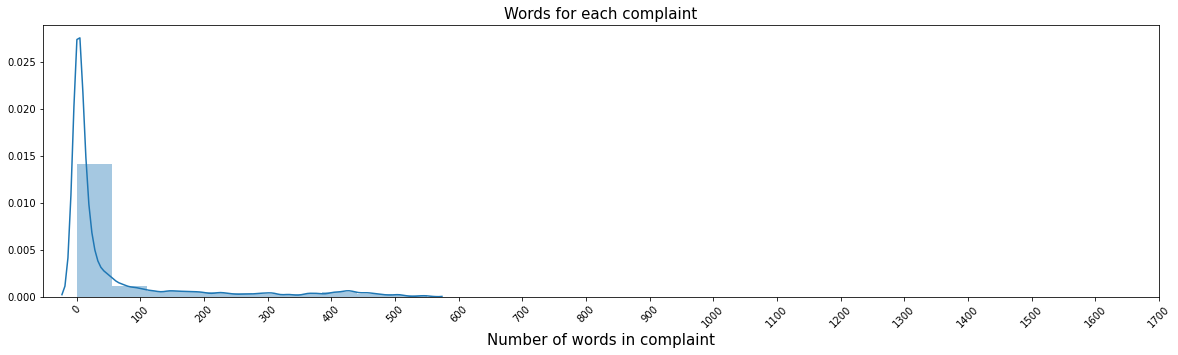

In [253]:
import seaborn as sns

plt.figure(figsize=(20,5))
sns.distplot(word_count.values, bins=10)
plt.title('Words for each complaint', fontsize=15)
plt.xlabel('Number of words in complaint', fontsize=15)
x_ticks = np.arange(0, 1800,100)
plt.xticks(x_ticks, rotation=45)
plt.show()

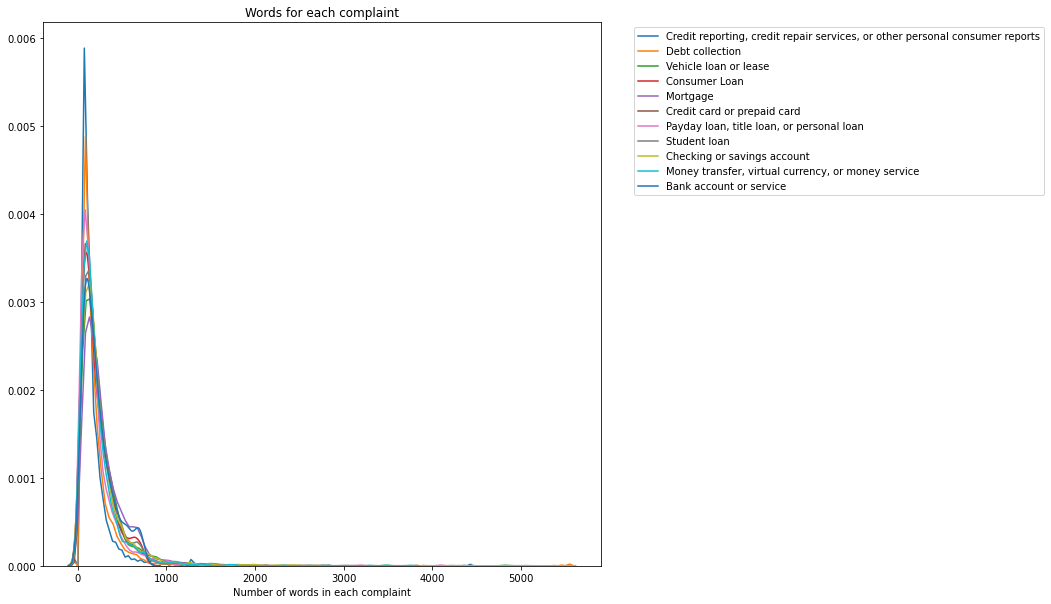

In [254]:
plt.figure(figsize=(10,10))

for category in df['product'].unique():
    category_word_count = df[df['product']==category]['consumer_complaint_narrative'].str.split().apply(len)
    category_word_count = category_word_count.values
    sns.distplot(category_word_count, hist=False, label=category)

plt.title('Words for each complaint')
plt.xlabel('Number of words in each complaint')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()   

> All the product categories have similar distribution in term of number of words

### Overall Wordcloud

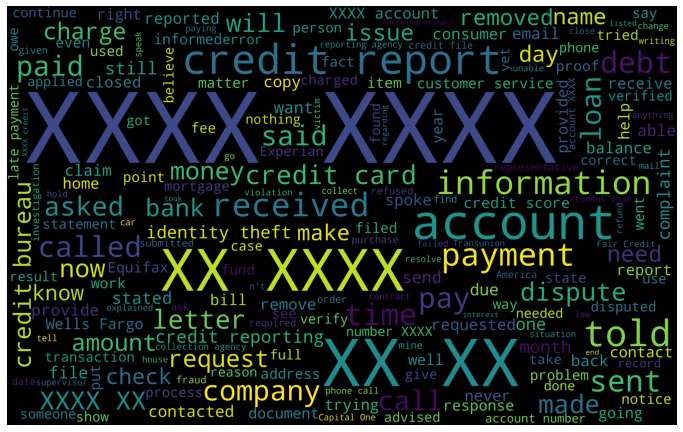

In [255]:
words = ' '.join(df['consumer_complaint_narrative'])
from wordcloud import WordCloud,STOPWORDS
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=4000,
                      height=2500
                     ).generate(words)
plt.figure(1,figsize=(12, 15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Frequently Used words

In [256]:
freq = pd.Series(' '.join(df['consumer_complaint_narrative']).split()).value_counts()[:30]
freq

XXXX       724637
the        714537
I          648129
to         625064
and        501135
my         361901
a          360571
of         325473
that       280158
was        233675
in         196768
on         195347
have       189141
not        177969
is         173946
for        167786
they       159928
this       156599
with       153289
me         139497
credit     138899
from       112423
it         100653
account     96242
(           94758
as          93704
be          88835
)           78158
or          75204
XXXX,       74511
dtype: int64

### Rarely used words

In [257]:
low_freq = pd.Series(' '.join(df['consumer_complaint_narrative']).split()).value_counts()[-30:]
low_freq

12-hour                 1
pg2                     1
Bottomline              1
Serif                   1
p8                      1
Eqiifax                 1
curse!                  1
self-renew              1
petite                  1
ABBREVIATION,           1
ME,????                 1
republic,               1
one.Which               1
govt.letter             1
issues/communication    1
stolen/                 1
Childsupport            1
TDbank.com.             1
VAST                    1
tuna-round              1
attonerys               1
brady                   1
Authenticated           1
winning.                1
approch                 1
purchses                1
Credit/Deferred         1
innocents,              1
lawtermcontract.        1
yPal                    1
dtype: int64

In [258]:
#### Printing one example from each category:

for i, category in enumerate(df['product'].unique()):
    print('*********')
    print("Category ", i, category)
    print('---------')
    category_word_count = df[df['product']==category]['consumer_complaint_narrative'].values[0]
    print(category_word_count)

*********
Category  0 Credit reporting, credit repair services, or other personal consumer reports
---------
There were somehow three hard hits on my account today. 1 I recognized, but 2 I did not.
*********
Category  1 Debt collection
---------
I received an miscellaneous fee on my auto loan some months back. I questioned the amount which was {$50.00}. Once I learned what the charge was for I was ok with paying that amount. My vehicle was held for evidence and I was fully aware that it wouldnt be released until I received an District attorney release. This release would be sent to me and only me. The finance company told me that they provided a lawyer and would see about getting the vehicle released, this is when I was charged the {$50.00} amount. I received 2 more payments and was told after the first one that the amount wouldnt increase especially after I stated that Im not aware of any charges and that there shouldnt be any charges especially when my situation doesnt involve any pa

And my XXXX XXXX XXXX Exspired today ... and I sent a XXXX As well with a Notery to the people at Westren Union as well with what is a Insurance receipt for delivery from the Post Office..with tracking numbers Reqlusal  relivance of Notery within Reqlusal beats copy of I'd!!!! Ofcourse within whome gets notery Amritrad Obligations.
*********
Category  10 Bank account or service
---------
I have XXXX debit card transactions that occurred a day prior to an ATM withdrawal ( ATM withdrawal resulted in an overdraft of the account ). However, the ATM withdrawal ( which occurred a day after the debit transactions ) posted to the account before the XXXX debit card transactions, so instead of an overdraft fee ( {$35.00} ) for the ATM withdrawal I received XXXX overdraft fees ( {$140.00} ). XXXX for the withdrawal and XXXX for each of the debit transactions. I called the bank ( Wells Fargo ) and spoke with a customer service agent and then a supervisor ( XXXX XXXX ). The supervisor repeatedly re

> text has numerical digits, punctuations, and alphabets. We will have to clean the text data.

In [259]:
df['consumer_complaint_narrative'][2:3].values[0]

'I received a call from XXXX advising me my account was past due, and l told her no it is not, l told there there is an error, she told me l needed to contact XXXX, which l did on XX/XX/2020 who told me they will reach out to Peritus, in the meantime XXXX told me that they would have repossessed and l told here for what was she talking about that l am 100 % current on my loan and payments. I am asking your department to get ask for an update of what the discretion is as XXXX tols me it is not in arrears and that also they told me Peritus has not sent over payment l spoke to XXXX a supervsior at XXXX. I have email confirmations on all payments. There calls are recorded on XX/XX/2020 l submitted payment, then on XX/XX/2020 l called to see what the problem was that my payment had not gone through the bank XXXX said it did not go through, so l said it never went to my bank as my bank verified they never attempted to send the payment to my checking account and that is what prompted me to ca

Steps to clean the data:
    
    > convert all the text to lower case
    
    > clean html tags if any
    
    > clear the punctuations
    
    > remove digits in text
    
    > decontraction
    
    > remove stopwords

In [2]:
#https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings
#data = data_raw
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
def cleanHtml(sentence): #function to clear html points
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext
stop_words = list(set(stopwords.words('english')))
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)

def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)


def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r' ',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/|_|-]',r' ',cleaned)
    cleaned = re.sub(r'[X]+',r'',cleaned)  #removing XXXX type words
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

def keepAlpha(sentence): #function to keep only alpha value
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word.lower()
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent


def remove_short_words(text):   #here we will remove words which have length <=2
    cleaned_text = " ".join(word.strip() for word in text.split() if len(word)>2 )
            
    return cleaned_text


In [260]:
df['consumer_complaint_narrative'] = df['consumer_complaint_narrative'].apply(cleanHtml)
df['consumer_complaint_narrative'] = df['consumer_complaint_narrative'].apply(removeStopWords)
df['consumer_complaint_narrative'] = df['consumer_complaint_narrative'].apply(cleanPunc)
df['consumer_complaint_narrative'] = df['consumer_complaint_narrative'].apply(keepAlpha)
df['consumer_complaint_narrative'] = df['consumer_complaint_narrative'].apply(remove_short_words)

### Checking the cleaned text

In [261]:
#### Printing one cleaned example from each category:

for i, category in enumerate(df['product'].unique()):
    print('*********')
    print("Category ", i, category)
    print('---------')
    category_word_count = df[df['product']==category]['consumer_complaint_narrative'].values[0]
    print(category_word_count)

*********
Category  0 Credit reporting, credit repair services, or other personal consumer reports
---------
somehow three hard hits account today recognized
*********
Category  1 Debt collection
---------
received miscellaneous fee auto loan months back questioned amount learned charge paying amount vehicle held evidence fully aware wouldnt released received district attorney release release would sent finance company told provided lawyer would see getting vehicle released charged amount received payments told first one amount wouldnt increase especially stated aware charges shouldnt charges especially situation doesnt involve payment situation going months finally idea taken place especially finance company told vehicle held dwi false held accountable towing fees also false charges would held accountable since district attorney possession would making necessary arrangements vehicle transported destination right fees doesnt make sense pay especially know money would pocket whole ordea

> Now the text is in much better format.

In [379]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date_received                 99999 non-null  object
 1   product                       99999 non-null  object
 2   consumer_complaint_narrative  99999 non-null  object
 3   company_public_response       99999 non-null  object
 4   company                       99999 non-null  object
 5   state                         99999 non-null  object
 6   tags                          99999 non-null  object
 7   consumer_consent_provided     99999 non-null  object
 8   submitted_via                 99999 non-null  object
 9   date_sent_to_company          99999 non-null  object
 10  company_response_to_consumer  99999 non-null  object
 11  timely_response               99999 non-null  object
 12  consumer_disputed             99999 non-null  object
 13  date_received_da

> Due to text cleaning, 4 consumer_complaint_narrative  have become null values. Hence we will fill these null values.

In [131]:
##filling the nan values
df['consumer_complaint_narrative'] = df['consumer_complaint_narrative'].fillna("unknown")


In [132]:
df.to_csv("cleaned.csv")

In [183]:
df = pd.read_csv("cleaned.csv")

In [184]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'date_received',
       'product', 'consumer_complaint_narrative', 'company_public_response',
       'company', 'state', 'tags', 'consumer_consent_provided',
       'submitted_via', 'date_sent_to_company', 'company_response_to_consumer',
       'timely_response', 'consumer_disputed', 'date_received_days',
       'date_sent_to_company_days', 'totalwords'],
      dtype='object')

In [185]:
df.drop(columns = ['Unnamed: 0'] , inplace = True)
df.drop(columns = ['Unnamed: 0.1'] , inplace = True)
df.drop(columns = ['Unnamed: 0.1.1'] , inplace = True)

In [186]:
df.columns

Index(['date_received', 'product', 'consumer_complaint_narrative',
       'company_public_response', 'company', 'state', 'tags',
       'consumer_consent_provided', 'submitted_via', 'date_sent_to_company',
       'company_response_to_consumer', 'timely_response', 'consumer_disputed',
       'date_received_days', 'date_sent_to_company_days', 'totalwords'],
      dtype='object')

In [187]:
df.reset_index(inplace = True, drop= True)


In [188]:
df.head()

,date_received,product,consumer_complaint_narrative,company_public_response,company,state,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,date_received_days,date_sent_to_company_days,totalwords
0,2018-09-07,"Credit reporting, credit repair services, or o...",somehow three hard hits account today recognized,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,unknown,Consent provided,Web,2018-09-13,Closed with explanation,Yes,unknown,1268,1274,18
1,2020-10-28,Debt collection,received miscellaneous fee auto loan months ba...,unknown,NISSAN MOTOR ACCEPTANCE CORPORATION,NY,unknown,Consent provided,Web,2020-10-28,Closed with explanation,Yes,unknown,2050,2050,298
2,2020-02-06,Vehicle loan or lease,received call advising account past due told t...,unknown,"Peritus Portfolio Services II, LLC",VA,unknown,Consent provided,Web,2020-02-06,Closed with non-monetary relief,Yes,unknown,1785,1785,395
3,2016-09-28,Consumer Loan,began getting collection phone calls behalf ac...,unknown,"Populus Financial Group, Inc.",MO,unknown,Consent provided,Web,2016-09-28,Closed with explanation,Yes,No,559,559,142
4,2018-12-11,Mortgage,mortgage bought another company called lakevie...,Company has responded to the consumer and the ...,"LAKEVIEW LOAN SERVICING, LLC",IL,unknown,Consent provided,Web,2018-12-11,Closed with explanation,Yes,unknown,1363,1363,204


In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date_received                 99999 non-null  object
 1   product                       99999 non-null  object
 2   consumer_complaint_narrative  99999 non-null  object
 3   company_public_response       99999 non-null  object
 4   company                       99999 non-null  object
 5   state                         99999 non-null  object
 6   tags                          99999 non-null  object
 7   consumer_consent_provided     99999 non-null  object
 8   submitted_via                 99999 non-null  object
 9   date_sent_to_company          99999 non-null  object
 10  company_response_to_consumer  99999 non-null  object
 11  timely_response               99999 non-null  object
 12  consumer_disputed             99999 non-null  object
 13  date_received_da

### Cleaning the categorical columns

In [190]:
df.columns

Index(['date_received', 'product', 'consumer_complaint_narrative',
       'company_public_response', 'company', 'state', 'tags',
       'consumer_consent_provided', 'submitted_via', 'date_sent_to_company',
       'company_response_to_consumer', 'timely_response', 'consumer_disputed',
       'date_received_days', 'date_sent_to_company_days', 'totalwords'],
      dtype='object')

#### company_public_response

In [191]:
df['company_public_response'].unique()

array(['Company has responded to the consumer and the CFPB and chooses not to provide a public response',
       'unknown',
       'Company believes it acted appropriately as authorized by contract or law',
       'Company chooses not to provide a public response',
       'Company believes complaint represents an opportunity for improvement to better serve consumers',
       'Company believes complaint is the result of an isolated error',
       'Company believes the complaint is the result of a misunderstanding',
       "Company can't verify or dispute the facts in the complaint",
       'Company believes complaint caused principally by actions of third party outside the control or direction of the company',
       'Company disputes the facts presented in the complaint',
       'Company believes complaint relates to a discontinued policy or procedure',
       "Company believes the complaint provided an opportunity to answer consumer's questions"],
      dtype=object)

> This we will clean and then combine with the complaint narration column

In [192]:
#df['company_public_response'] = df['company_public_response'].apply(cleanHtml)
df['company_public_response'] = df['company_public_response'].apply(removeStopWords)
df['company_public_response'] = df['company_public_response'].apply(cleanPunc)
df['company_public_response'] = df['company_public_response'].apply(keepAlpha)
df['company_public_response'] = df['company_public_response'].apply(remove_short_words)

In [193]:
df['company_public_response'].value_counts()

unknown                                                                                                50880
company responded consumer cfpb chooses provide public response                                        38165
company believes acted appropriately authorized contract law                                            6002
company chooses provide public response                                                                 2549
company believes complaint result misunderstanding                                                       589
company disputes facts presented complaint                                                               542
company believes complaint caused principally actions third party outside control direction company      389
company believes complaint result isolated error                                                         340
company believes complaint represents opportunity improvement better serve consumers                     258
company verify disp

In [194]:
df["final_text"] = df["consumer_complaint_narrative"] + df["company_public_response"]
df["final_text"].head()

0    somehow three hard hits account today recogniz...
1    received miscellaneous fee auto loan months ba...
2    received call advising account past due told t...
3    began getting collection phone calls behalf ac...
4    mortgage bought another company called lakevie...
Name: final_text, dtype: object

#### state

In [195]:
df['state'].unique()

array(['CA', 'NY', 'VA', 'MO', 'IL', 'CO', 'GA', 'NJ', 'IN', 'FL', 'NE',
       'MS', 'CT', 'NM', 'MD', 'TX', 'PA', 'NC', 'WA', 'TN', 'DC', 'OH',
       'AR', 'OR', 'UT', 'KS', 'AZ', 'MN', 'WI', 'MA', 'AE', 'MI', 'AL',
       'NV', 'MT', 'DE', 'SC', 'unknown', 'ME', 'LA', 'OK', 'NH', 'KY',
       'AA', 'HI', 'GU', 'SD', 'IA', 'PR', 'ID', 'RI', 'VT', 'AP', 'AK',
       'WY', 'WV', 'ND', 'VI', 'UNITED STATES MINOR OUTLYING ISLANDS',
       'FM', 'PW', 'AS'], dtype=object)

In [196]:
def clean_text_category(text):
    text = re.sub(r'[?|!|\'|"|#|&]',r' ',text)
    text = re.sub(r'[.|,|)|(|\|/|_|-]',r' ',text)
    text = "_".join(word.strip().lower() for word in text.split())
    return(text)

In [197]:
df['state'] = df['state'].apply(clean_text_category)


In [198]:
df['state'].unique()

array(['ca', 'ny', 'va', 'mo', 'il', 'co', 'ga', 'nj', 'in', 'fl', 'ne',
       'ms', 'ct', 'nm', 'md', 'tx', 'pa', 'nc', 'wa', 'tn', 'dc', 'oh',
       'ar', 'or', 'ut', 'ks', 'az', 'mn', 'wi', 'ma', 'ae', 'mi', 'al',
       'nv', 'mt', 'de', 'sc', 'unknown', 'me', 'la', 'ok', 'nh', 'ky',
       'aa', 'hi', 'gu', 'sd', 'ia', 'pr', 'id', 'ri', 'vt', 'ap', 'ak',
       'wy', 'wv', 'nd', 'vi', 'united_states_minor_outlying_islands',
       'fm', 'pw', 'as'], dtype=object)

#### company

In [199]:
df['company'].unique()

array(['TRANSUNION INTERMEDIATE HOLDINGS, INC.',
       'NISSAN MOTOR ACCEPTANCE CORPORATION',
       'Peritus Portfolio Services II, LLC', ...,
       'Law offices of Steven Cohen LLC', 'MORTGAGE CLEARING CORPORATION',
       'Secured Resolutions, LLC'], dtype=object)

In [200]:
df['company'] = df['company'].apply(clean_text_category)
df['company'].unique()

array(['transunion_intermediate_holdings_inc',
       'nissan_motor_acceptance_corporation',
       'peritus_portfolio_services_ii_llc', ...,
       'law_offices_of_steven_cohen_llc', 'mortgage_clearing_corporation',
       'secured_resolutions_llc'], dtype=object)

#### tags

In [201]:
df['tags'].unique()

array(['unknown', 'Servicemember', 'Older American, Servicemember',
       'Older American'], dtype=object)

In [202]:
df['tags'] = df['tags'].str.replace(' ','')
df['tags'] = df['tags'].str.replace(',',' ')
df['tags'] = df['tags'].str.lower()
df['tags'].value_counts()

unknown                        83866
servicemember                  10075
olderamerican                   4770
olderamerican servicemember     1288
Name: tags, dtype: int64

#### company_response_to_consumer

In [203]:
df['company_response_to_consumer'].unique()

array(['Closed with explanation', 'Closed with non-monetary relief',
       'Closed', 'Closed with monetary relief', 'Untimely response'],
      dtype=object)

In [204]:
df['company_response_to_consumer'] = df['company_response_to_consumer'].str.replace(' ','_')
df['company_response_to_consumer'] = df['company_response_to_consumer'].str.replace('-','_')
df['company_response_to_consumer'] = df['company_response_to_consumer'].str.lower()
df['company_response_to_consumer'].value_counts()

closed_with_explanation            83550
closed_with_non_monetary_relief    10669
closed_with_monetary_relief         4800
untimely_response                    532
closed                               448
Name: company_response_to_consumer, dtype: int64

#### timely_response

In [205]:
df['timely_response'].unique()

array(['Yes', 'No'], dtype=object)

In [206]:
df['timely_response'] = df['timely_response'].str.lower()
df['timely_response'].value_counts()

yes    97806
no      2193
Name: timely_response, dtype: int64

#### consumer_disputed

In [207]:
df['consumer_disputed'].unique()

array(['unknown', 'No', 'Yes'], dtype=object)

In [208]:
df['consumer_disputed'] = df['consumer_disputed'].str.lower()
df['consumer_disputed'].value_counts()

unknown    78492
no         16758
yes         4749
Name: consumer_disputed, dtype: int64

#### product

In [209]:
df['product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    42008
Debt collection                                                                 19693
Mortgage                                                                        10747
Credit card or prepaid card                                                     10251
Checking or savings account                                                      4457
Student loan                                                                     3747
Money transfer, virtual currency, or money service                               2441
Bank account or service                                                          2013
Vehicle loan or lease                                                            1874
Payday loan, title loan, or personal loan                                        1524
Consumer Loan                                                                    1244
Name: product, dtype: int64

In [210]:
df['product'] = df['product'].str.replace(',','')
df['product'] = df['product'].str.replace(' ','_')
df['product'] = df['product'].str.lower()
df['product'].value_counts()

credit_reporting_credit_repair_services_or_other_personal_consumer_reports    42008
debt_collection                                                               19693
mortgage                                                                      10747
credit_card_or_prepaid_card                                                   10251
checking_or_savings_account                                                    4457
student_loan                                                                   3747
money_transfer_virtual_currency_or_money_service                               2441
bank_account_or_service                                                        2013
vehicle_loan_or_lease                                                          1874
payday_loan_title_loan_or_personal_loan                                        1524
consumer_loan                                                                  1244
Name: product, dtype: int64

> categorical column cleaning done.

> we will do one hot encoding for consumer_disputed, timely_response, company_response_to_consumer, tags.

> we will use word embedding for state and company names

# 5. Spiling the data into train, val and test

> Since we have a date feature. It is a recommeded to do splitting based on time. We will split the data in 70:15:15 ratio, based on time. Latest data will come in test dataset.

In [211]:
#first sorting the data by date_received column
df = df.sort_values('date_received')
df.head()

,date_received,product,consumer_complaint_narrative,company_public_response,company,state,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,date_received_days,date_sent_to_company_days,totalwords,final_text
70944,2015-03-19,consumer_loan,applied loan purchased vehicle month told woul...,unknown,hyundai_capital_america,ms,unknown,Consent provided,Web,2015-03-19,closed_with_explanation,yes,no,0,0,558,applied loan purchased vehicle month told woul...
65721,2015-03-19,debt_collection,sent letter regarding matter however response ...,unknown,wells_fargo_company,md,servicemember,Consent provided,Web,2015-04-13,closed_with_explanation,yes,no,0,25,124,sent letter regarding matter however response ...
65434,2015-03-19,credit_reporting_credit_repair_services_or_oth...,disputing incorrect information experian credi...,company chooses provide public response,experian_information_solutions_inc,fl,unknown,Consent provided,Web,2015-03-19,closed_with_explanation,yes,no,0,0,67,disputing incorrect information experian credi...
31069,2015-03-19,credit_card_or_prepaid_card,complaint regards credit card bank america pay...,company chooses provide public response,bank_of_america_national_association,nj,unknown,Consent provided,Web,2015-03-19,closed_with_non_monetary_relief,yes,yes,0,0,523,complaint regards credit card bank america pay...
3904,2015-03-19,mortgage,approved trial modification select portfolio s...,company believes acted appropriately authorize...,select_portfolio_servicing_inc,ca,unknown,Consent provided,Web,2015-03-19,closed_with_explanation,yes,yes,0,0,537,approved trial modification select portfolio s...


In [212]:
#reseting the index
df.reset_index(inplace = True, drop = True)
df.head()

,date_received,product,consumer_complaint_narrative,company_public_response,company,state,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,date_received_days,date_sent_to_company_days,totalwords,final_text
0,2015-03-19,consumer_loan,applied loan purchased vehicle month told woul...,unknown,hyundai_capital_america,ms,unknown,Consent provided,Web,2015-03-19,closed_with_explanation,yes,no,0,0,558,applied loan purchased vehicle month told woul...
1,2015-03-19,debt_collection,sent letter regarding matter however response ...,unknown,wells_fargo_company,md,servicemember,Consent provided,Web,2015-04-13,closed_with_explanation,yes,no,0,25,124,sent letter regarding matter however response ...
2,2015-03-19,credit_reporting_credit_repair_services_or_oth...,disputing incorrect information experian credi...,company chooses provide public response,experian_information_solutions_inc,fl,unknown,Consent provided,Web,2015-03-19,closed_with_explanation,yes,no,0,0,67,disputing incorrect information experian credi...
3,2015-03-19,credit_card_or_prepaid_card,complaint regards credit card bank america pay...,company chooses provide public response,bank_of_america_national_association,nj,unknown,Consent provided,Web,2015-03-19,closed_with_non_monetary_relief,yes,yes,0,0,523,complaint regards credit card bank america pay...
4,2015-03-19,mortgage,approved trial modification select portfolio s...,company believes acted appropriately authorize...,select_portfolio_servicing_inc,ca,unknown,Consent provided,Web,2015-03-19,closed_with_explanation,yes,yes,0,0,537,approved trial modification select portfolio s...


In [213]:
y = df['product'].values
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
y_label = labelencoder.fit_transform(y)
onehotencoder = OneHotEncoder()
y_hot = onehotencoder.fit_transform(y_label.reshape(-1, 1)).toarray()
y_hot

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [214]:
df_train  = df[0:int(df.shape[0]*0.70)]
print(df_train.shape)
df_train.head()

(69999, 17)


,date_received,product,consumer_complaint_narrative,company_public_response,company,state,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,date_received_days,date_sent_to_company_days,totalwords,final_text
0,2015-03-19,consumer_loan,applied loan purchased vehicle month told woul...,unknown,hyundai_capital_america,ms,unknown,Consent provided,Web,2015-03-19,closed_with_explanation,yes,no,0,0,558,applied loan purchased vehicle month told woul...
1,2015-03-19,debt_collection,sent letter regarding matter however response ...,unknown,wells_fargo_company,md,servicemember,Consent provided,Web,2015-04-13,closed_with_explanation,yes,no,0,25,124,sent letter regarding matter however response ...
2,2015-03-19,credit_reporting_credit_repair_services_or_oth...,disputing incorrect information experian credi...,company chooses provide public response,experian_information_solutions_inc,fl,unknown,Consent provided,Web,2015-03-19,closed_with_explanation,yes,no,0,0,67,disputing incorrect information experian credi...
3,2015-03-19,credit_card_or_prepaid_card,complaint regards credit card bank america pay...,company chooses provide public response,bank_of_america_national_association,nj,unknown,Consent provided,Web,2015-03-19,closed_with_non_monetary_relief,yes,yes,0,0,523,complaint regards credit card bank america pay...
4,2015-03-19,mortgage,approved trial modification select portfolio s...,company believes acted appropriately authorize...,select_portfolio_servicing_inc,ca,unknown,Consent provided,Web,2015-03-19,closed_with_explanation,yes,yes,0,0,537,approved trial modification select portfolio s...


In [215]:
y_train  = y_hot[0:int(df.shape[0]*0.70)]
print(y_train.shape)

y_train

(69999, 11)


array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [216]:
df_train.tail()

,date_received,product,consumer_complaint_narrative,company_public_response,company,state,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,date_received_days,date_sent_to_company_days,totalwords,final_text
69994,2020-04-13,credit_reporting_credit_repair_services_or_oth...,filed dispute credit reporting agencies regard...,company responded consumer cfpb chooses provid...,transunion_intermediate_holdings_inc,il,unknown,Consent provided,Web,2020-04-13,closed_with_explanation,yes,unknown,1852,1852,64,filed dispute credit reporting agencies regard...
69995,2020-04-13,credit_card_or_prepaid_card,summer received email usaa credit card company...,company believes acted appropriately authorize...,united_services_automobile_association,oh,servicemember,Consent provided,Web,2020-04-13,closed_with_non_monetary_relief,yes,unknown,1852,1852,377,summer received email usaa credit card company...
69996,2020-04-13,credit_card_or_prepaid_card,dear sir madam american express decided suspen...,unknown,american_express_company,va,unknown,Consent provided,Web,2020-04-13,closed_with_explanation,yes,unknown,1852,1852,202,dear sir madam american express decided suspen...
69997,2020-04-13,credit_reporting_credit_repair_services_or_oth...,time report inconsistencies aes based actual b...,unknown,aes_pheaa,pa,unknown,Consent provided,Web,2020-04-13,closed_with_explanation,yes,unknown,1852,1852,137,time report inconsistencies aes based actual b...
69998,2020-04-13,credit_reporting_credit_repair_services_or_oth...,numerous occasions disputed accounts credit re...,company responded consumer cfpb chooses provid...,experian_information_solutions_inc,mi,unknown,Consent provided,Web,2020-04-13,closed_with_explanation,yes,unknown,1852,1852,77,numerous occasions disputed accounts credit re...


In [217]:
df_val  = df[df_train.shape[0]:int(df.shape[0]*0.85)]
print(df_val.shape)
df_val.head()

(15000, 17)


,date_received,product,consumer_complaint_narrative,company_public_response,company,state,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,date_received_days,date_sent_to_company_days,totalwords,final_text
69999,2020-04-13,credit_reporting_credit_repair_services_or_oth...,use authorized user credit card someone else t...,company responded consumer cfpb chooses provid...,transunion_intermediate_holdings_inc,ca,unknown,Consent provided,Web,2020-04-13,closed_with_explanation,yes,unknown,1852,1852,87,use authorized user credit card someone else t...
70000,2020-04-13,credit_reporting_credit_repair_services_or_oth...,avictimof inaccurate unverifiable invalid outd...,company responded consumer cfpb chooses provid...,transunion_intermediate_holdings_inc,sc,unknown,Consent provided,Web,2020-04-13,closed_with_explanation,yes,unknown,1852,1852,150,avictimof inaccurate unverifiable invalid outd...
70001,2020-04-13,debt_collection,received call began threatening client would p...,unknown,crown_asset_management_llc_duluth_ga_branch,mo,unknown,Consent provided,Web,2020-04-21,closed_with_explanation,yes,unknown,1852,1860,260,received call began threatening client would p...
70002,2020-04-13,mortgage,dear sir madam owned home years always made pa...,unknown,jpmorgan_chase_co,ca,olderamerican servicemember,Consent provided,Web,2020-04-13,closed_with_explanation,yes,unknown,1852,1852,159,dear sir madam owned home years always made pa...
70003,2020-04-13,credit_reporting_credit_repair_services_or_oth...,sent ftc violation updated company ftc make de...,unknown,equifax_inc,tx,unknown,Consent provided,Web,2020-04-13,closed_with_explanation,yes,unknown,1852,1852,23,sent ftc violation updated company ftc make de...


In [218]:
df_val.reset_index(inplace = True, drop = True)
df_val.head()

,date_received,product,consumer_complaint_narrative,company_public_response,company,state,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,date_received_days,date_sent_to_company_days,totalwords,final_text
0,2020-04-13,credit_reporting_credit_repair_services_or_oth...,use authorized user credit card someone else t...,company responded consumer cfpb chooses provid...,transunion_intermediate_holdings_inc,ca,unknown,Consent provided,Web,2020-04-13,closed_with_explanation,yes,unknown,1852,1852,87,use authorized user credit card someone else t...
1,2020-04-13,credit_reporting_credit_repair_services_or_oth...,avictimof inaccurate unverifiable invalid outd...,company responded consumer cfpb chooses provid...,transunion_intermediate_holdings_inc,sc,unknown,Consent provided,Web,2020-04-13,closed_with_explanation,yes,unknown,1852,1852,150,avictimof inaccurate unverifiable invalid outd...
2,2020-04-13,debt_collection,received call began threatening client would p...,unknown,crown_asset_management_llc_duluth_ga_branch,mo,unknown,Consent provided,Web,2020-04-21,closed_with_explanation,yes,unknown,1852,1860,260,received call began threatening client would p...
3,2020-04-13,mortgage,dear sir madam owned home years always made pa...,unknown,jpmorgan_chase_co,ca,olderamerican servicemember,Consent provided,Web,2020-04-13,closed_with_explanation,yes,unknown,1852,1852,159,dear sir madam owned home years always made pa...
4,2020-04-13,credit_reporting_credit_repair_services_or_oth...,sent ftc violation updated company ftc make de...,unknown,equifax_inc,tx,unknown,Consent provided,Web,2020-04-13,closed_with_explanation,yes,unknown,1852,1852,23,sent ftc violation updated company ftc make de...


In [219]:
y_val  = y_hot[df_train.shape[0]:int(df.shape[0]*0.85)]
print(y_val.shape)

y_val

(15000, 11)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [220]:
df_test  = df[int(df.shape[0]*0.85):]
print(df_test.shape)
df_test.head()

(15000, 17)


,date_received,product,consumer_complaint_narrative,company_public_response,company,state,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,date_received_days,date_sent_to_company_days,totalwords,final_text
84999,2020-11-25,credit_reporting_credit_repair_services_or_oth...,sent letters credit bureaus inaccurate informa...,company responded consumer cfpb chooses provid...,experian_information_solutions_inc,ny,unknown,Consent provided,Web,2020-11-25,closed_with_explanation,yes,unknown,2078,2078,55,sent letters credit bureaus inaccurate informa...
85000,2020-11-25,credit_card_or_prepaid_card,received card unemployment illinois services k...,unknown,keycorp,il,unknown,Consent provided,Web,2020-11-25,closed_with_explanation,yes,unknown,2078,2078,114,received card unemployment illinois services k...
85001,2020-11-25,credit_reporting_credit_repair_services_or_oth...,fed loan servicing reported late payment speak...,unknown,aes_pheaa,mi,unknown,Consent provided,Web,2020-11-25,closed_with_explanation,yes,unknown,2078,2078,78,fed loan servicing reported late payment speak...
85002,2020-11-25,credit_reporting_credit_repair_services_or_oth...,tried submit numerous disputes company regards...,company responded consumer cfpb chooses provid...,transunion_intermediate_holdings_inc,mn,unknown,Consent provided,Web,2020-11-25,closed_with_explanation,yes,unknown,2078,2078,39,tried submit numerous disputes company regards...
85003,2020-11-25,credit_reporting_credit_repair_services_or_oth...,may concern writing dispute fraudulent charge ...,company responded consumer cfpb chooses provid...,transunion_intermediate_holdings_inc,ca,unknown,Consent provided,Web,2020-11-25,closed_with_explanation,yes,unknown,2078,2078,251,may concern writing dispute fraudulent charge ...


In [221]:
y_test  = y_hot[int(df.shape[0]*0.85):]
print(y_test.shape)
y_test

(15000, 11)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [222]:
df_test.reset_index(inplace = True, drop = True)
df_test.head()

,date_received,product,consumer_complaint_narrative,company_public_response,company,state,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,date_received_days,date_sent_to_company_days,totalwords,final_text
0,2020-11-25,credit_reporting_credit_repair_services_or_oth...,sent letters credit bureaus inaccurate informa...,company responded consumer cfpb chooses provid...,experian_information_solutions_inc,ny,unknown,Consent provided,Web,2020-11-25,closed_with_explanation,yes,unknown,2078,2078,55,sent letters credit bureaus inaccurate informa...
1,2020-11-25,credit_card_or_prepaid_card,received card unemployment illinois services k...,unknown,keycorp,il,unknown,Consent provided,Web,2020-11-25,closed_with_explanation,yes,unknown,2078,2078,114,received card unemployment illinois services k...
2,2020-11-25,credit_reporting_credit_repair_services_or_oth...,fed loan servicing reported late payment speak...,unknown,aes_pheaa,mi,unknown,Consent provided,Web,2020-11-25,closed_with_explanation,yes,unknown,2078,2078,78,fed loan servicing reported late payment speak...
3,2020-11-25,credit_reporting_credit_repair_services_or_oth...,tried submit numerous disputes company regards...,company responded consumer cfpb chooses provid...,transunion_intermediate_holdings_inc,mn,unknown,Consent provided,Web,2020-11-25,closed_with_explanation,yes,unknown,2078,2078,39,tried submit numerous disputes company regards...
4,2020-11-25,credit_reporting_credit_repair_services_or_oth...,may concern writing dispute fraudulent charge ...,company responded consumer cfpb chooses provid...,transunion_intermediate_holdings_inc,ca,unknown,Consent provided,Web,2020-11-25,closed_with_explanation,yes,unknown,2078,2078,251,may concern writing dispute fraudulent charge ...


In [223]:
print(len(y_train))
print((df_train.shape))
print(len(y_val))
print((df_val.shape))
print(len(y_test))
print((df_test.shape))


69999
(69999, 17)
15000
(15000, 17)
15000
(15000, 17)


In [224]:
df_train['product'][6]

'mortgage'

In [225]:
y_train[6]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

# 6. Encoding numerical, categorical features

In [226]:
from sklearn.feature_extraction.text import CountVectorizer


In [227]:
df_train.columns

Index(['date_received', 'product', 'consumer_complaint_narrative',
       'company_public_response', 'company', 'state', 'tags',
       'consumer_consent_provided', 'submitted_via', 'date_sent_to_company',
       'company_response_to_consumer', 'timely_response', 'consumer_disputed',
       'date_received_days', 'date_sent_to_company_days', 'totalwords',
       'final_text'],
      dtype='object')

#### One Hot Encoding of Categorical Variables

> we will do one hot encoding for consumer_disputed, timely_response, company_response_to_consumer, tags.

In [228]:
column_name = 'consumer_disputed'
vectorizer_2 = CountVectorizer()
vectorizer_2.fit(df_train[column_name].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_consumer_disputed_ohe = vectorizer_2.transform(df_train[column_name].values)
X_val_consumer_disputed_ohe = vectorizer_2.transform(df_val[column_name].values)
X_test_consumer_disputed_ohe = vectorizer_2.transform(df_test[column_name].values)

print("After vectorizations")
print(X_train_consumer_disputed_ohe.shape, y_train.shape)
print(X_val_consumer_disputed_ohe.shape, y_val.shape)
print(X_test_consumer_disputed_ohe.shape, y_test.shape)

print(vectorizer_2.get_feature_names())
print("="*100)

After vectorizations
(69999, 3) (69999, 11)
(15000, 3) (15000, 11)
(15000, 3) (15000, 11)
['no', 'unknown', 'yes']


In [229]:
column_name = 'timely_response'
vectorizer_3 = CountVectorizer()
vectorizer_3.fit(df_train[column_name].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_timely_response_ohe = vectorizer_3.transform(df_train[column_name].values)
X_val_timely_response_ohe = vectorizer_3.transform(df_val[column_name].values)
X_test_timely_response_ohe = vectorizer_3.transform(df_test[column_name].values)

print("After vectorizations")
print(X_train_timely_response_ohe.shape, y_train.shape)
print(X_val_timely_response_ohe.shape, y_val.shape)
print(X_test_timely_response_ohe.shape, y_test.shape)
print(vectorizer_3.get_feature_names())
print("="*100)

After vectorizations
(69999, 2) (69999, 11)
(15000, 2) (15000, 11)
(15000, 2) (15000, 11)
['no', 'yes']


In [230]:
column_name = 'company_response_to_consumer'
vectorizer_4 = CountVectorizer()
vectorizer_4.fit(df_train[column_name].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_company_response_to_consumer_ohe = vectorizer_4.transform(df_train[column_name].values)
X_val_company_response_to_consumer_ohe = vectorizer_4.transform(df_val[column_name].values)
X_test_company_response_to_consumer_ohe = vectorizer_4.transform(df_test[column_name].values)

print("After vectorizations")
print(X_train_company_response_to_consumer_ohe.shape, y_train.shape)
print(X_val_company_response_to_consumer_ohe.shape, y_val.shape)
print(X_test_company_response_to_consumer_ohe.shape, y_test.shape)
print(vectorizer_4.get_feature_names())
print("="*100)

After vectorizations
(69999, 5) (69999, 11)
(15000, 5) (15000, 11)
(15000, 5) (15000, 11)
['closed', 'closed_with_explanation', 'closed_with_monetary_relief', 'closed_with_non_monetary_relief', 'untimely_response']


In [231]:
column_name = 'tags'
vectorizer_5 = CountVectorizer()
vectorizer_5.fit(df_train[column_name].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_tags_ohe = vectorizer_5.transform(df_train[column_name].values)
X_val_tags_ohe = vectorizer_5.transform(df_val[column_name].values)
X_test_tags_ohe = vectorizer_5.transform(df_test[column_name].values)

print("After vectorizations")
print(X_train_tags_ohe.shape, y_train.shape)
print(X_val_tags_ohe.shape, y_val.shape)
print(X_test_tags_ohe.shape, y_test.shape)
print(vectorizer_5.get_feature_names())
print("="*100)

After vectorizations
(69999, 3) (69999, 11)
(15000, 3) (15000, 11)
(15000, 3) (15000, 11)
['olderamerican', 'servicemember', 'unknown']


#### Normalizing the Numerical Variables

In [51]:
df.columns

Index(['date_received', 'product', 'consumer_complaint_narrative',
       'company_public_response', 'company', 'state', 'tags',
       'consumer_consent_provided', 'submitted_via', 'date_sent_to_company',
       'company_response_to_consumer', 'timely_response', 'consumer_disputed',
       'date_received_days', 'date_sent_to_company_days', 'totalwords',
       'final_text'],
      dtype='object')

In [232]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(df_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(df_train['date_received_days'].values.reshape(1,-1))

X_train_received_days_norm = normalizer.transform(df_train['date_received_days'].values.reshape(1,-1))
X_val_received_days_norm = normalizer.transform(df_val['date_received_days'].values.reshape(1,-1))
X_test_received_days_norm = normalizer.transform(df_test['date_received_days'].values.reshape(1,-1))

X_train_received_days_norm = X_train_received_days_norm.reshape(-1,1)
X_val_received_days_norm = X_val_received_days_norm.reshape(-1,1)
X_test_received_days_norm = X_test_received_days_norm.reshape(-1,1)


print("After normalization")
print(X_train_received_days_norm.shape, y_train.shape)
print(X_val_received_days_norm.shape, y_val.shape)
print(X_test_received_days_norm.shape, y_test.shape)
print("="*100)

After normalization
(69999, 1) (69999, 11)
(15000, 1) (15000, 11)
(15000, 1) (15000, 11)


In [233]:
from sklearn.preprocessing import Normalizer
normalizer2 = Normalizer()
# normalizer.fit(df_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer2.fit(df_train['date_sent_to_company_days'].values.reshape(1,-1))

X_train_sent_days_norm = normalizer2.transform(df_train['date_sent_to_company_days'].values.reshape(1,-1))
X_val_sent_days_norm = normalizer2.transform(df_val['date_sent_to_company_days'].values.reshape(1,-1))
X_test_sent_days_norm = normalizer2.transform(df_test['date_sent_to_company_days'].values.reshape(1,-1))

X_train_sent_days_norm = X_train_sent_days_norm.reshape(-1,1)
X_val_sent_days_norm = X_val_sent_days_norm.reshape(-1,1)
X_test_sent_days_norm = X_test_sent_days_norm.reshape(-1,1)


print("After normalization")
print(X_train_sent_days_norm.shape, y_train.shape)
print(X_val_sent_days_norm.shape, y_val.shape)
print(X_test_sent_days_norm.shape, y_test.shape)
print("="*100)

After normalization
(69999, 1) (69999, 11)
(15000, 1) (15000, 11)
(15000, 1) (15000, 11)


In [234]:
from sklearn.preprocessing import Normalizer
normalizer3 = Normalizer()
# normalizer.fit(df_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer3.fit(df_train['totalwords'].values.reshape(1,-1))

X_train_totalwords_norm = normalizer3.transform(df_train['totalwords'].values.reshape(1,-1))
X_val_totalwords_norm = normalizer3.transform(df_val['totalwords'].values.reshape(1,-1))
X_test_totalwords_norm = normalizer3.transform(df_test['totalwords'].values.reshape(1,-1))

X_train_totalwords_norm = X_train_totalwords_norm.reshape(-1,1)
X_val_totalwords_norm = X_val_totalwords_norm.reshape(-1,1)
X_test_totalwords_norm = X_test_totalwords_norm.reshape(-1,1)


print("After normalization")
print(X_train_totalwords_norm.shape, y_train.shape)
print(X_val_totalwords_norm.shape, y_val.shape)
print(X_test_totalwords_norm.shape, y_test.shape)
print("="*100)

After normalization
(69999, 1) (69999, 11)
(15000, 1) (15000, 11)
(15000, 1) (15000, 11)


### Concatinating the Encoded and Numerical features

In [235]:
feature_list = [X_train_consumer_disputed_ohe,X_train_timely_response_ohe, X_train_company_response_to_consumer_ohe,X_train_tags_ohe, X_train_received_days_norm, X_train_sent_days_norm,X_train_totalwords_norm ]

In [236]:
for feature in feature_list:
    print(type(feature))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [237]:
X_train_consumer_disputed_ohe = X_train_consumer_disputed_ohe.todense()
X_train_timely_response_ohe = X_train_timely_response_ohe.todense()
X_train_company_response_to_consumer_ohe = X_train_company_response_to_consumer_ohe.todense()
X_train_tags_ohe = X_train_tags_ohe.todense()

In [238]:
X_val_consumer_disputed_ohe = X_val_consumer_disputed_ohe.todense()
X_val_timely_response_ohe = X_val_timely_response_ohe.todense()
X_val_company_response_to_consumer_ohe = X_val_company_response_to_consumer_ohe.todense()
X_val_tags_ohe = X_val_tags_ohe.todense()

In [239]:
X_test_consumer_disputed_ohe = X_test_consumer_disputed_ohe.todense()
X_test_timely_response_ohe = X_test_timely_response_ohe.todense()
X_test_company_response_to_consumer_ohe = X_test_company_response_to_consumer_ohe.todense()
X_test_tags_ohe = X_test_tags_ohe.todense()

In [240]:
for feature in feature_list:
    print(type(feature))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [241]:
for feature in feature_list:
    print(feature.shape)

(69999, 3)
(69999, 2)
(69999, 5)
(69999, 3)
(69999, 1)
(69999, 1)
(69999, 1)


In [243]:
X_tr_encoded_num = np.concatenate((X_train_consumer_disputed_ohe,X_train_timely_response_ohe, X_train_company_response_to_consumer_ohe,X_train_tags_ohe, X_train_received_days_norm, X_train_sent_days_norm,X_train_totalwords_norm), axis=1)
X_va_encoded_num = np.concatenate((X_val_consumer_disputed_ohe,X_val_timely_response_ohe, X_val_company_response_to_consumer_ohe,X_val_tags_ohe, X_val_received_days_norm, X_val_sent_days_norm,X_val_totalwords_norm), axis=1)
X_te_encoded_num = np.concatenate((X_test_consumer_disputed_ohe, X_test_timely_response_ohe, X_test_company_response_to_consumer_ohe,X_test_tags_ohe,X_test_received_days_norm, X_test_sent_days_norm, X_test_totalwords_norm), axis=1)
print("Encoded and Numerical Data matrix")
print(X_tr_encoded_num.shape, y_train.shape)
print(type(X_tr_encoded_num))
print(X_va_encoded_num.shape, y_val.shape)
print(type(X_va_encoded_num))
print(X_te_encoded_num.shape, y_test.shape)
print(type(X_te_encoded_num))
print("="*100)

Encoded and Numerical Data matrix
(69999, 16) (69999, 11)
<class 'numpy.matrix'>
(15000, 16) (15000, 11)
<class 'numpy.matrix'>
(15000, 16) (15000, 11)
<class 'numpy.matrix'>


In [80]:
'''# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr_encoded_num = hstack((X_train_consumer_disputed_ohe,X_train_timely_response_ohe, X_train_company_response_to_consumer_ohe,X_train_tags_ohe, X_train_received_days_norm, X_train_sent_days_norm,X_train_totalwords_norm   )).tocsr()
X_te_encoded_num = hstack((X_test_consumer_disputed_ohe, X_test_timely_response_ohe, X_test_company_response_to_consumer_ohe,X_test_tags_ohe,X_test_received_days_norm, X_test_sent_days_norm, X_test_totalwords_norm  )).tocsr()

print("Encoded and Numerical Data matrix")
print(X_tr_encoded_num.shape, y_train.shape)
print(X_te_encoded_num.shape, y_test.shape)
print("="*100)'''

'# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039\nfrom scipy.sparse import hstack\nX_tr_encoded_num = hstack((X_train_consumer_disputed_ohe,X_train_timely_response_ohe, X_train_company_response_to_consumer_ohe,X_train_tags_ohe, X_train_received_days_norm, X_train_sent_days_norm,X_train_totalwords_norm   )).tocsr()\nX_te_encoded_num = hstack((X_test_consumer_disputed_ohe, X_test_timely_response_ohe, X_test_company_response_to_consumer_ohe,X_test_tags_ohe,X_test_received_days_norm, X_test_sent_days_norm, X_test_totalwords_norm  )).tocsr()\n\nprint("Encoded and Numerical Data matrix")\nprint(X_tr_encoded_num.shape, y_train.shape)\nprint(X_te_encoded_num.shape, y_test.shape)\nprint("="*100)'

### Featurizing the text data i.e. encoding the data into numbers

In [244]:
X_train_final_text = df_train['final_text'].values
X_val_final_text = df_val['final_text'].values
X_test_final_text = df_test['final_text'].values

print("Final Text Feature")
print(X_train_final_text.shape, y_train.shape)
print(X_val_final_text.shape, y_val.shape)
print(X_test_final_text.shape, y_test.shape)
print("="*100)

Final Text Feature
(69999,) (69999, 11)
(15000,) (15000, 11)
(15000,) (15000, 11)


First we will get basic info about the data. i.e. number of words in each mail, total number of words in corpus etc.

In [245]:
#total unique word cound in whole corpus
len(set((' ').join(df['final_text'].values).split()))

59000

In [246]:
#total unique word cound in train corpus
len(set((' ').join(df_train['final_text'].values).split()))

51486

In [247]:
#total unique word cound in test corpus
len(set((' ').join(df_test['final_text'].values).split()))

21763

In [248]:
df['totalwords_after_cleaning'] = df['final_text'].str.split().str.len()
df['totalwords_after_cleaning'].describe()

count    99999.000000
mean        86.891019
std        103.063556
min          1.000000
25%         32.000000
50%         58.000000
75%        105.000000
max       2791.000000
Name: totalwords_after_cleaning, dtype: float64

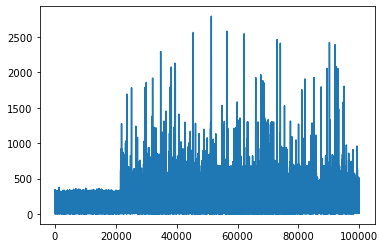

In [249]:
df['totalwords_after_cleaning'].plot()

> From the plot, we can see that most of the mails have less than 1000 total words. Hence we will consider 1000 as our length each mail.

> Total words in the corpus is 59000

In [250]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding


num_words = 59000
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

# Tokenize our training data
tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token, filters='!"#$%&()*+,-/:;<=>?@[\\]^`{|}~\t\n') #not filtering "_"
tokenizer.fit_on_texts(X_train_final_text)

# Get our training  data word index
word_index = tokenizer.word_index

# Encode training and test data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(X_train_final_text)
val_sequences = tokenizer.texts_to_sequences(X_val_final_text)
test_sequences = tokenizer.texts_to_sequences(X_test_final_text)

# Get max training and test sequence length
maxlen = 1000    

# Pad the training  and test sequences
train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)
val_padded = pad_sequences(val_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

# Output the results of our work
#print("Word index:\n", word_index)
#print("\nTraining sequences:\n", train_sequences)
#print("\nPadded training sequences:\n", train_padded)
print("\nPadded training shape:", train_padded.shape)
print("Training sequences data type:", type(train_sequences))
print("Padded Training sequences data type:", type(train_padded))
print("\nPadded validation shape:", val_padded.shape)
print("validation sequences data type:", type(val_sequences))
print("Padded validation sequences data type:", type(val_padded))
print("\nPadded test shape:", test_padded.shape)
print("test sequences data type:", type(test_sequences))
print("Padded test sequences data type:", type(test_padded))



Padded training shape: (69999, 1000)
Training sequences data type: <class 'list'>
Padded Training sequences data type: <class 'numpy.ndarray'>

Padded validation shape: (15000, 1000)
validation sequences data type: <class 'list'>
Padded validation sequences data type: <class 'numpy.ndarray'>

Padded test shape: (15000, 1000)
test sequences data type: <class 'list'>
Padded test sequences data type: <class 'numpy.ndarray'>


### Creating the word embedding matrix

> Here we will take pre-trained 100d golve vectors for final text features. We will not train the model explicitly.

> for state and company variables, we will use word embedding which we will train in the model itself.

In [251]:
# load the whole embedding into memory
from tqdm import tqdm
embeddings_index = dict()
f = open('glove.6B.100d.txt',encoding="utf8")
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

400000it [00:21, 18460.30it/s]

Loaded 400000 word vectors.


In [252]:
# create a weight matrix for words in training docs
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = zeros((vocab_size, 100))


for word, i in tokenizer.word_index.items():
    word = word.lower()
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is None:
        embedding_vector = embeddings_index.get(word.replace('_', '-'))
        if embedding_vector is None:
            embedding_vector = embeddings_index.get(word.replace('_', ''))
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [253]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding

X_train_state = df_train['state'].values
X_val_state = df_val['state'].values
X_test_state = df_test['state'].values

num_words_state = len(df_train['state'].unique())
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

# Tokenize our training data
tokenizer2 = Tokenizer(num_words=num_words_state, oov_token=oov_token, filters='!"#$%&()*+,-/:;<=>?@[\\]^`{|}~\t\n') #not filtering "_"
tokenizer2.fit_on_texts(X_train_state)

# Get our training  data word index
word_index_state = tokenizer2.word_index

# Encode training and test data sentences into sequences
train_sequences_state = np.array(tokenizer2.texts_to_sequences(X_train_state))
val_sequences_state = np.array(tokenizer2.texts_to_sequences(X_val_state))
test_sequences_state = np.array(tokenizer2.texts_to_sequences(X_test_state))

###########
#there is no padding required since the lenth of the each input is 1 (same)

# Get max training and test sequence length
#maxlen = 1    

# Pad the training  and test sequences
#train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)
#test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

# Output the results of our work
#print("Word index:\n", word_index)
#print("\nTraining sequences:\n", train_sequences)
#print("\nPadded training sequences:\n", train_padded)
print("\nPadded training shape:", train_sequences_state.shape)
print("Training sequences data type:", type(train_sequences_state))
print("\nPadded validation shape:", val_sequences_state.shape)
print("validation sequences data type:", type(val_sequences_state))
#print("Padded Training sequences data type:", type(train_padded))
print("\nPadded test shape:", test_sequences_state.shape)
print("test sequences data type:", type(test_sequences_state))
#print("Padded test sequences data type:", type(test_padded))



Padded training shape: (69999, 1)
Training sequences data type: <class 'numpy.ndarray'>

Padded validation shape: (15000, 1)
validation sequences data type: <class 'numpy.ndarray'>

Padded test shape: (15000, 1)
test sequences data type: <class 'numpy.ndarray'>


In [254]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding

X_train_company = df_train['company'].values
X_val_company = df_val['company'].values
X_test_company = df_test['company'].values

num_words_company = len(df_train['company'].unique())
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

# Tokenize our training data
tokenizer3 = Tokenizer(num_words=num_words_company, oov_token=oov_token, filters='!"#$%&()*+,-/:;<=>?@[\\]^`{|}~\t\n') #not filtering "_"
tokenizer3.fit_on_texts(X_train_company)

# Get our training  data word index
word_index_company = tokenizer3.word_index

# Encode training and test data sentences into sequences
train_sequences_company = tokenizer3.texts_to_sequences(X_train_company)
val_sequences_company = tokenizer3.texts_to_sequences(X_val_company)
test_sequences_company = tokenizer3.texts_to_sequences(X_test_company)



###########
#there is no padding required since the lenth of the each input is 1 (same)

# Get max training and test sequence length
maxlen = 1    

# Pad the training  and test sequences
train_padded_company = pad_sequences(train_sequences_company, padding=pad_type, truncating=trunc_type, maxlen=maxlen)
val_padded_company = pad_sequences(val_sequences_company, padding=pad_type, truncating=trunc_type, maxlen=maxlen)
test_padded_company = pad_sequences(test_sequences_company, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

# Output the results of our work
#print("Word index:\n", word_index)
#print("\nTraining sequences:\n", train_sequences)
#print("\nPadded training sequences:\n", train_padded)
print("\nPadded training shape:", train_padded_company.shape)
print("Training sequences data type:", type(train_padded_company))
#print("Padded Training sequences data type:", type(train_padded))

print("\nPadded validation shape:", val_padded_company.shape)
print("Training validation data type:", type(val_padded_company))

print("\nPadded test shape:", test_padded_company.shape)
print("test sequences data type:", type(test_padded_company))
#print("Padded test sequences data type:", type(test_padded))



Padded training shape: (69999, 1)
Training sequences data type: <class 'numpy.ndarray'>

Padded validation shape: (15000, 1)
Training validation data type: <class 'numpy.ndarray'>

Padded test shape: (15000, 1)
test sequences data type: <class 'numpy.ndarray'>


# 7. Model Building

In [281]:
#https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
import tensorflow as tf
import keras
val_features_list = [val_padded,val_sequences_state,val_padded_company,X_va_encoded_num ]
class Metrics(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(val_features_list))).round()
        val_targ = y_val
        _val_f1 = f1_score(val_targ, val_predict, average='micro')
        _val_recall = recall_score(val_targ, val_predict, average='micro')
        _val_precision = precision_score(val_targ, val_predict, average='micro')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print (" — val_f1: %f — val_precision: %f — val_recall %f" %(_val_f1, _val_precision, _val_recall))

        return

     
metrics = Metrics()

In [282]:
#define model

#https://www.kaggle.com/au1206/text-classification-using-cnn

from tensorflow.keras.layers import Activation, Conv2D, Input, Embedding, Reshape, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Conv1D, MaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, EarlyStopping, TerminateOnNaN, TensorBoard
from tensorflow.keras.optimizers import Adam
import datetime, os
from tensorflow.keras.layers import LSTM


drop = 0.5

MAX_SEQUENCE_LENGTH = 1000

##########################
### text input
input1 = Input(shape=(1000,), name = 'final_text')
#print(input1.shape)
embedding_layer1 = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=1000, trainable=False)
embedding1 = embedding_layer1(input1)
#print(embedding1.shape)
lstm1 = LSTM(100, dropout=0.2, recurrent_dropout=0.2)(embedding1)
flatten_final_text = Flatten()(lstm1)

##########################

### categorical embedding

#embedding layer for state
vocab_size_state = len(word_index_state) + 1

input2 = Input(shape=(1,), name = 'state')
#print(input2.shape)
embedding_layer2 = Embedding(vocab_size_state, 10, input_length=1)
embedding2 = embedding_layer2(input2)
#print(embedding2.shape)
flatten_state = Flatten()(embedding2)

##embedding layer for state
#size of each vector = 10, input length = 1
vocab_size_company = len(word_index_company) + 1

input3 = Input(shape=(1,), name = 'company')
#print(input3.shape)
embedding_layer3 = Embedding(vocab_size_company, 10, input_length=1)
embedding3 = embedding_layer3(input3)
#print(embedding3.shape)
flatten_company = Flatten()(embedding3)

##########################

## input for one hot encoded categorical and normlized numerical features

input4 = Input(shape=(16,), name = 'ohe_num')
encoded_num = Dense(units=100, activation='relu')(input4)

##########################

concatenated1 = Concatenate(axis=1)([flatten_final_text, flatten_state, flatten_company, encoded_num])

dense1 = Dense(100, activation='relu')(concatenated1)

dropout1 = Dropout(drop)(dense1)

dense2 = Dense(100, activation='relu')(dropout1)

dropout2 = Dropout(drop)(dense2)

dense3 = Dense(100, activation='relu')(dropout2)

output = Dense(units=11, activation='softmax')(dense3)

earlystop = EarlyStopping(monitor='val_acc', patience=5, verbose=1)
filepath="model_save/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
logdir = os.path.join("logss", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=logdir,histogram_freq=1, write_graph=True,write_grads=True)
metrics = Metrics()

checkpoint = ModelCheckpoint('weights_lstm.hdf5', monitor='val_accuracy', verbose=2, save_best_only=True, mode='auto')

callback_list = [earlystop,checkpoint, tensorboard_callback, metrics] 


model = Model(inputs=[input1, input2, input3, input4], outputs=output)

adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
final_text (InputLayer)         [(None, 1000)]       0                                            
__________________________________________________________________________________________________
embedding_30 (Embedding)        (None, 1000, 100)    5148800     final_text[0][0]                 
__________________________________________________________________________________________________
state (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
company (InputLayer)            [(None, 1)]          0                                            
___________________________________________________________________________________________

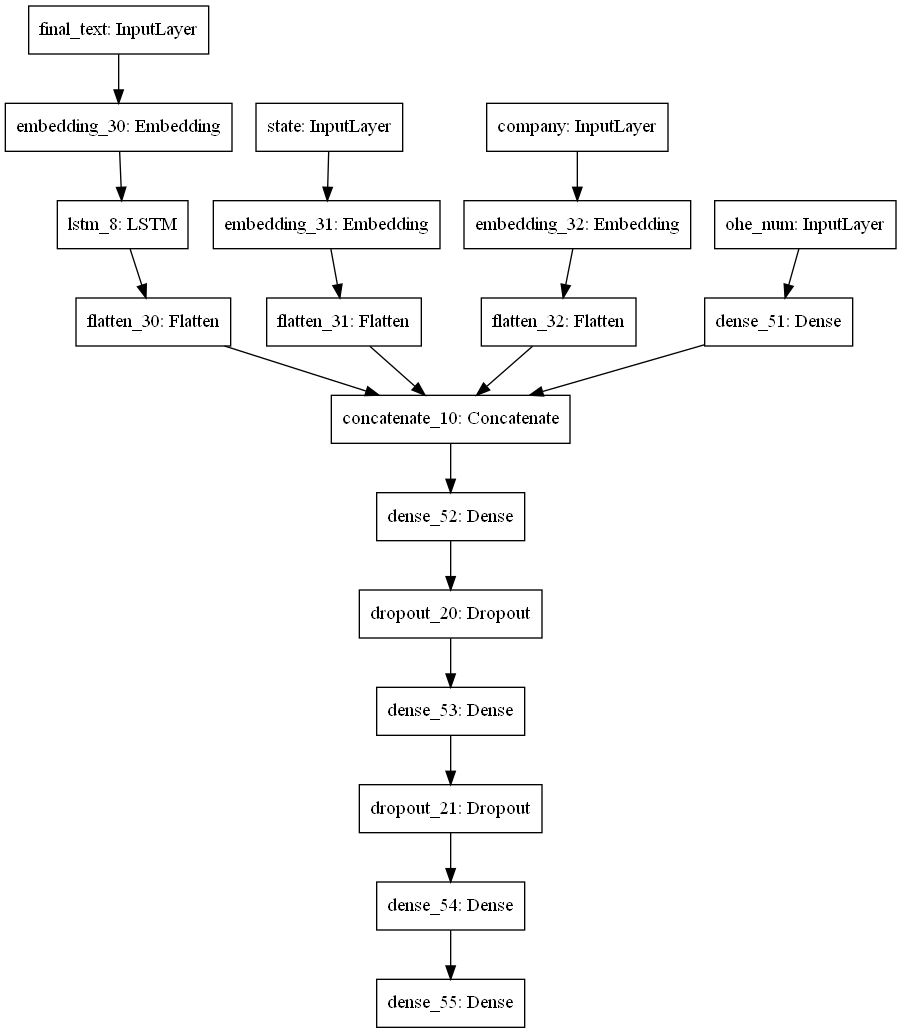

In [283]:
from tensorflow.keras.utils import plot_model
plot_model(model)

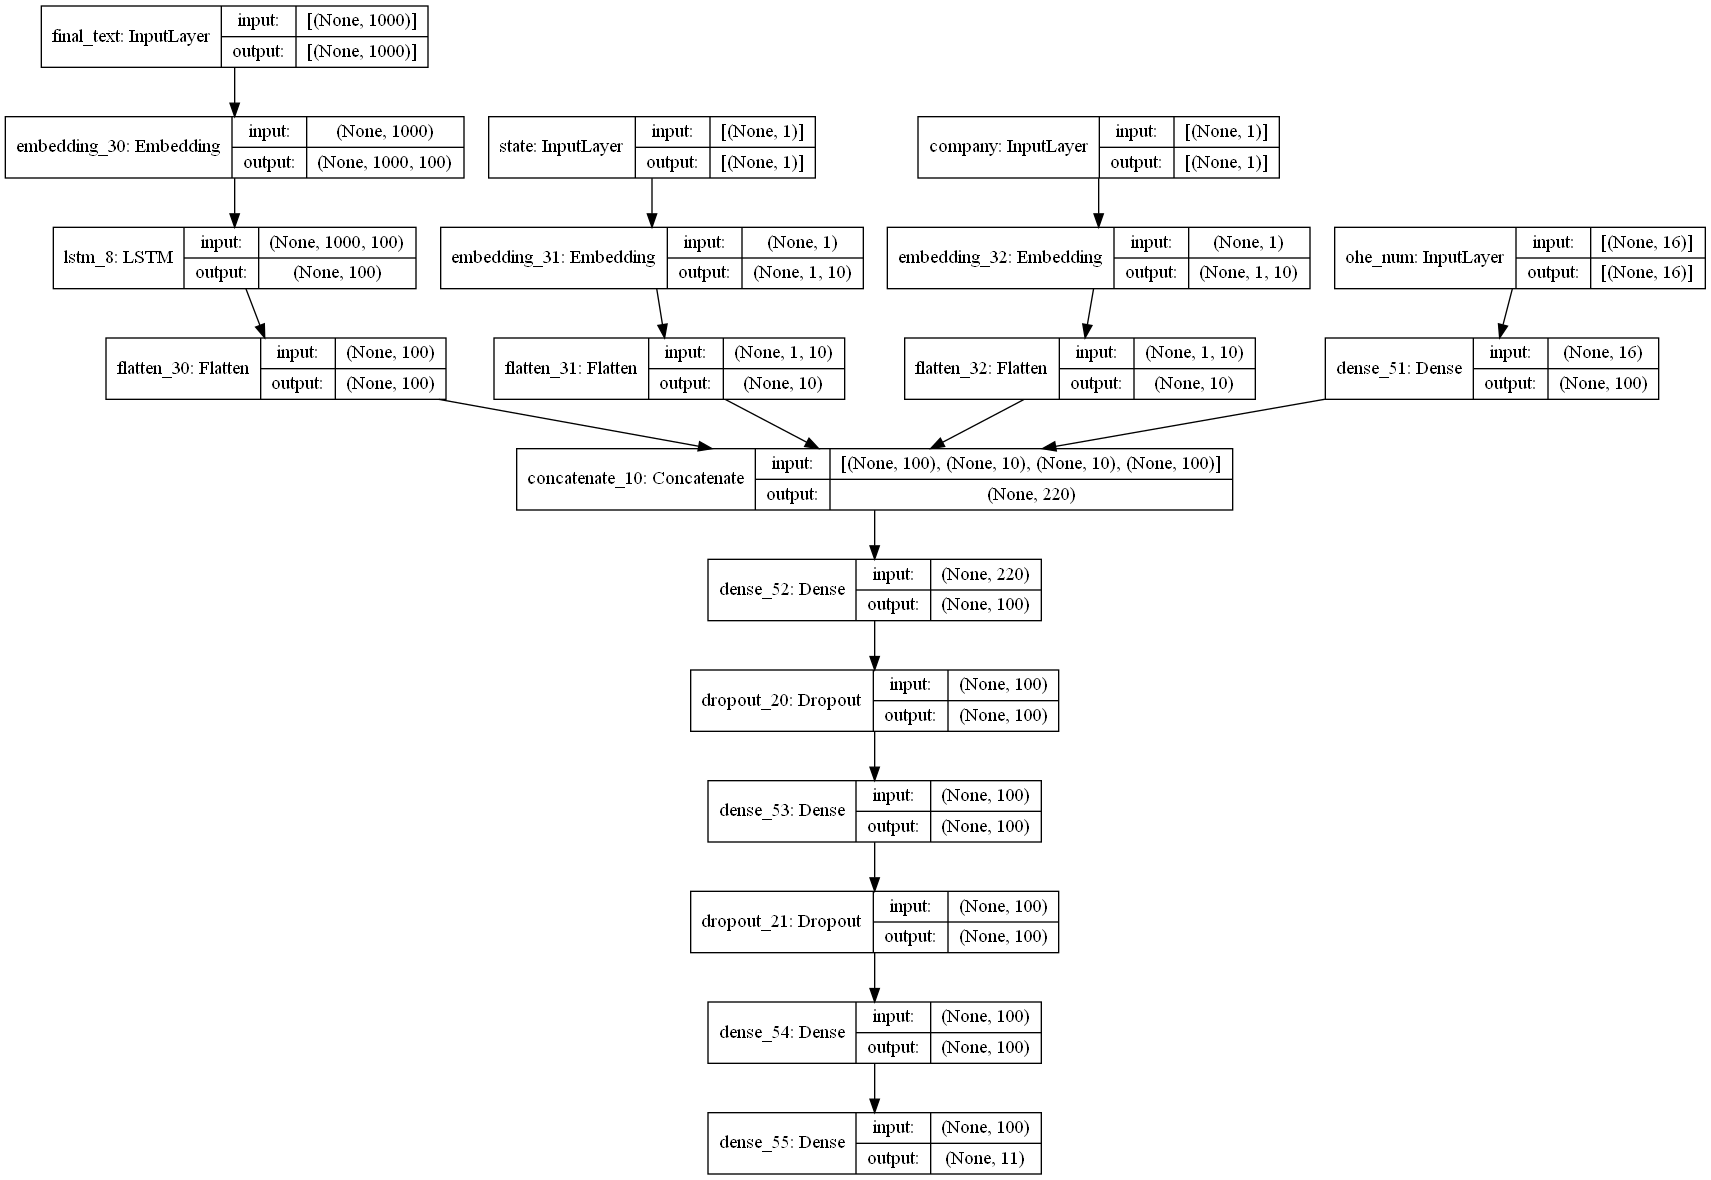

In [284]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
train_features = {"final_text" : train_padded, 
                       "state" : train_sequences_state, 
                       "company" : train_padded_company, 
                       "ohe_num" : X_tr_encoded_num}
val_features = {"final_text" : val_padded, 
                       "state" : val_sequences_state, 
                       "company" : val_padded_company, 
                       "ohe_num" : X_va_encoded_num}

model_history = model.fit(train_features, y_train, batch_size=256, epochs=50,  validation_data = (val_features, y_val), callbacks=[callback_list])


Epoch 1/50
 61/274 [=====>........................] - ETA: 2:20:06 - loss: 2.1820 - accuracy: 0.3564

# 8. Calculating test score

In [265]:
test_features = {"final_text" : test_padded, 
                       "state" : test_sequences_state, 
                       "company" : test_padded_company, 
                       "ohe_num" : X_te_encoded_num}
test_scores = model.evaluate(test_features, y_test, verbose=2)


469/469 - 231s - loss: 2.4205 - accuracy: 0.0151


In [274]:
test_features_list = [test_padded,test_sequences_state,test_padded_company,X_te_encoded_num ]

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
import tensorflow as tf
import keras
test_predict = (np.asarray(model.predict(test_features_list))).round()
test_targ = y_test
_test_f1 = f1_score(test_targ, test_predict, average='micro')
_test_recall = recall_score(test_targ, test_predict, average='micro')
_test_precision = precision_score(test_targ, test_predict, average='micro')

print (" test — test_f1: %f — test_precision: %f — test_recall %f" %(_test_f1, _test_precision, _test_recall))

 test — test_f1: 0.000000 — test_precision: 0.000000 — test_recall 0.000000


In [273]:
#val_features_list = [val_padded,val_sequences_state,val_padded_company,X_val_encoded_num ]

In [280]:
test_predict[5]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)